In [1]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams['text.usetex'] = True

from iminuit import Minuit
import sys
sys.path.insert(1,'DSS')
import fDSS_
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
i_FF = 0
FF_model = ["fDSSLO","fDSSNLO","JAM20","Geiger"]

with open('yield_ratio_xz_Q2cut_withRunGroups.json') as j_RD:
    RDxz = json.load(j_RD)
with open('yield_ratio_Q2xzRunG_Q2cut.json') as j_Q2xzRG:
    RD_Q2xzRG = json.load(j_Q2xzRG)
colors = ['antiquewhite','antiquewhite','aqua','aquamarine','azure','banana','bisque','blue','blueviolet','brown','burlywood','cadetblue','chartreuse','cornflowerblue','coral','crimson','darkgoldenrod','darkgreen','darkorange','darksalmon','darkorchid','darkseagreen','darkslateblue','darkslategrey','darkviolet','dimgray','firebrick','forestgreen','goldenrod','green','greenyellow','hotpink','indigo','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow']
def Get_weighted(values,errs):
    sums = 0
    sig = 0
    for i in range(len(values)):
        for j in range(len(errs)):
            sums+=values[i]/(errs[i]*errs[i])
            sig+=1/(errs[i]*errs[i])
    return sums/sig   
def Get_weighted_average(value,error):
    sum_mean = 0
    sum_sigma = 0
    for i in range(len(value)):
        sum_mean += value[i]/(error[i]*error[i])
        sum_sigma += 1/(error[i]*error[i])
    return sum_mean/sum_sigma
def Get_weighted_sigma(value,error):
    sum_sigma = 0
    for i in range(len(value)):
        sum_sigma += 1/(error[i]*error[i])
    return math.sqrt(1/sum_sigma)
def MRST_xCSV(x,k):
    return x*2*k*(1-x)**4*x**-0.5*(x-0.0909)


## Getting a PDF member object

p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq6 = lhapdf.mkPDF("cteq6l1/0")
JAM20 = lhapdf.mkPDF("JAM20-SIDIS_FF_pion_nlo", 0)
def Ax(Q,xbj):
    return -4/(3*(p_cteq6.xfxQ(2,xbj,Q)+p_cteq6.xfxQ(1,xbj,Q)))
def Bx(Q,xbj,z_had):
    B_NS = 5*(p_cteq6.xfxQ(-2,xbj,Q)+p_cteq6.xfxQ(-1,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    B_sz = (JAM20.xfxQ(3,z_had,Q)+JAM20.xfxQ(-3,z_had,Q))/JAM20.xfxQ(2,z_had,Q)/(1+JAM20.xfxQ(-2,z_had,Q)/JAM20.xfxQ(2,z_had,Q)) 
    B_S = B_sz*(p_cteq6.xfxQ(3,xbj,Q)+p_cteq6.xfxQ(-3,xbj,Q))/(p_cteq6.xfxQ(1,xbj,Q)+p_cteq6.xfxQ(2,xbj,Q))
    return  2.5+B_NS+B_S
    
    
def Get_D_fav(Q,z_had):
    """
    #Kretzer
    Dd_plus = 0.217*z_had**-1.805*(1-z_had)**2.037
    D_fav = Dd_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_fav = D_sum/(1.0+R_D)
    
    return D_fav
def Get_D_unfav(Q,z_had):
    """
    #Kretzer
    Du_plus = 0.689*z_had**-1.039*(1-z_had)**1.241
    D_unfav = Du_plus;
    """
    #Binneweis
    Lambda = 0.227
    sv = math.log(math.log(Q*Q/(Lambda**2))/math.log(2/Lambda**2))
    N = 1.150-1.522*sv+1.378*sv**2-0.527*sv**3
    a1 = -0.740-1.680*sv+1.546*sv**2-0.596*sv**3
    a2 = 1.430+0.543*sv-0.023*sv**2
    D_sum = N*z_had**a1*(1.0-z_had)**a2
    #Ratio of D-/D+ from P.Geiger's thesis HERMES
    R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
    D_unfav = D_sum/(1.0+1.0/R_D)
    
    return D_unfav
def Dz(Q,z_had):
     if i_FF == 0:
        #fDSS lo
        duplus = fDSS_.fdss(1,1,0,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,0,z_hadron,Q*Q)[0]
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
     elif i_FF == 1:
        #fDSS nlo
        duplus = fDSS_.fdss(1,1,1,z_hadron,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,1,z_hadron,Q*Q)[0]
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
     elif i_FF == 2:
        duplus = JAM20.xfxQ(2,z_hadron,Q)
        duminus = JAM20.xfxQ(-2,z_hadron,Q)
        delta_z = duminus/duplus
        return (1-delta_z)/(1+delta_z)
     elif i_FF == 3:
        #P.Geiger's thesis
        R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
        delta_z = R_D
        return (1-delta_z)/(1+delta_z) 
    

def CSVx(Q,z_had,xbj,RDmeas):
    return (Bx(Q,xbj,z_had)-Dz(Q,z_had)*(RDmeas+2.5))/Ax(Q,xbj)
def CSVx_err(Q,z_had,xbj,RDmeas):
    return Dz(Q,z_had)*(RDmeas)/Ax(Q,xbj)


LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_FF_pion_nlo/JAM20-SIDIS_FF_pion_nlo_0000.dat
JAM20-SIDIS_FF_pion_nlo PDF set, member #0, version 2


In [2]:
Q2s = [3.886,4.47459,5.053517]
Q2_str = ["Q2_1","Q2_2","Q2_3"]


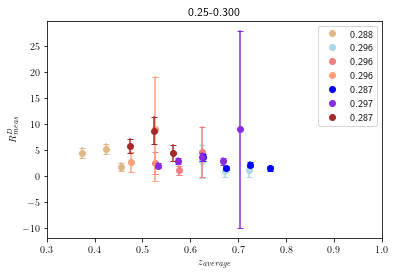

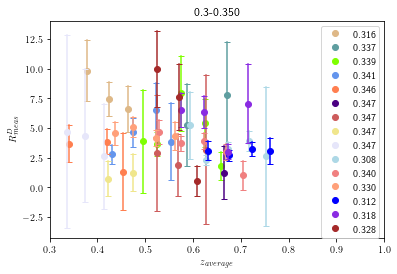

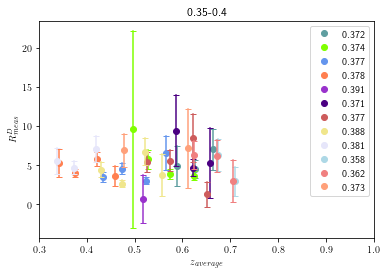

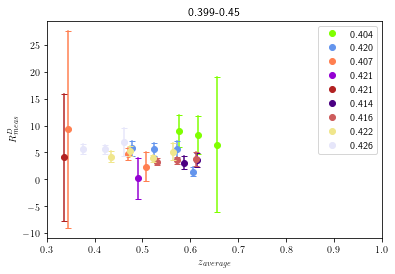

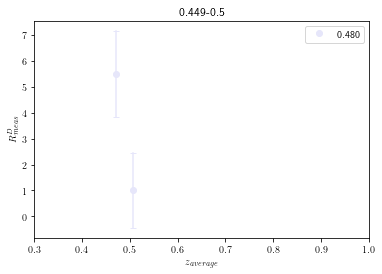

In [3]:
Q2 = Q2s[0]
for key_xbj,xbj_value in RDxz[Q2_str[0]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #print(xbj)
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])
            #print(z_value["xbj_corr"])
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        #print(xbj_corr)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = xbj_corr_str[0:5])
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        #RD_xbj = Get_weighted_average(RDs,RDs_error)
        #RD_xbj_err = Get_weighted_sigma(RDs,RDs_error)
        #RDs_xbj.append(RD_xbj)
        #RDs_xbj_err.append(RD_xbj_err)
        

In [4]:
xbj_ones_corr = []
CSV_ones = []
CSV_ones_err = []
xbj_twos_corr = []
CSV_twos = []
CSV_twos_err = []
xbj_threes_corr = []
CSV_threes = []
CSV_threes_err = []

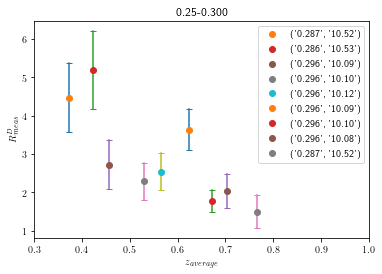

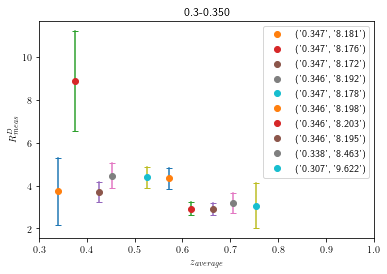

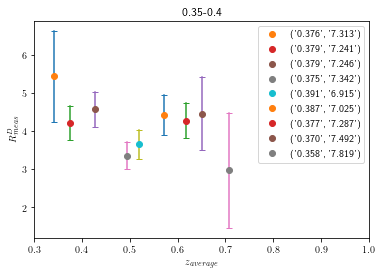

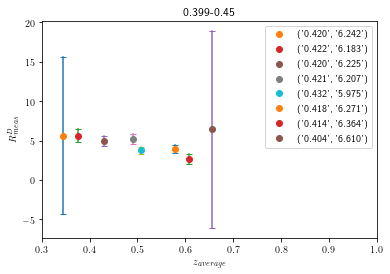

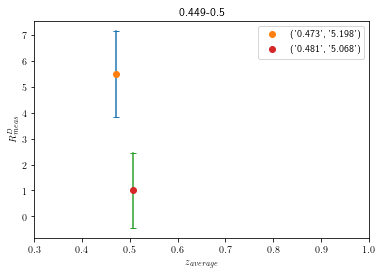

In [5]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
#ones Q2 <4, twos Q2 = 4-4.75, threes Q2 >4.75,

for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[0]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_one_corr = []
    xbj_one_err_corr = []
    CSV_one = []
    CSV_one_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            #print('RD_error ',RD_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        #print('RDs ',RDs)
        #print('RDs err ',RDs_error)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        #print('RD',RD)
        #print('RD_err',RD_err)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_one_corr.append(xbj_corr)
        xbj_onei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_one_err_corr.append(xbj_onei_err_corr)
        CSV_one.append(CSVxi)
        CSV_one_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        #plt.grid()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_one = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    xbj_ones_corr.append(xbj_one)
    #print('CSVs',CSV_one)
    #print('CSCVs err',CSV_one_err)
    CSVxi_one = Get_weighted_average(CSV_one,CSV_one_err)
    CSVxi_one_err = Get_weighted_sigma(CSV_one,CSV_one_err)
    #print('CSV one', CSVxi_one)
    #print('CSV one err',CSVxi_one_err)
    CSV_ones.append(CSVxi_one)
    CSV_ones_err.append(CSVxi_one_err)

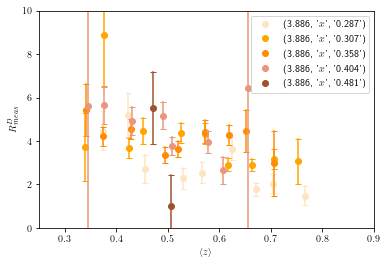

In [6]:
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[0]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.ylim(0,10)
    plt.legend()
    i_color +=1
    plt.savefig(f"/Users/shuojia/CSV/results/ratios/RDmeas_Q2st_Q2cut")

(-0.1, 0.15)

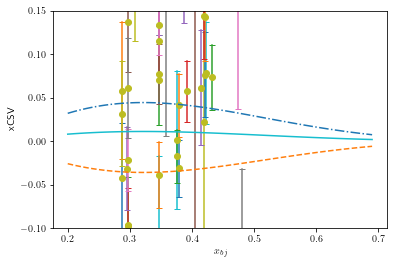

In [7]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")    
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
    
def delta_udv(parameter):
    x = np.arange(0.2,0.7,0.01)
    return x*parameter*(1-x)**4*x**-0.5*(x-0.0909)
x_axis = np.arange(0.2,0.7,0.01)
y_delta_uv = delta_udv(-0.2)
y_delta_dv = delta_udv(0.2)
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
y_delta_uv_up = delta_udv(0.8)
y_delta_uv_low = delta_udv(-0.8)
y_delta_dv_up = delta_udv(-0.65)
y_delta_dv_low = delta_udv(0.65)
#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel(r'$x_{bj}$')
plt.ylabel('xCSV')
plt.ylim(-0.1,0.15)

0.9954312700554768


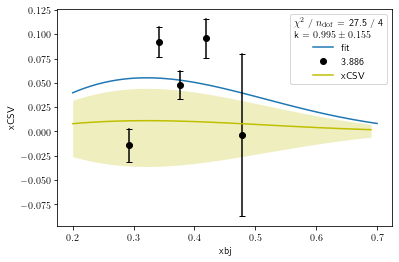

In [8]:
fig, ax = plt.subplots()
least_squares_one = LeastSquares(xbj_ones_corr,CSV_ones,CSV_ones_err,MRST_xCSV)
m_one = Minuit(least_squares_one, k=0.2)
m_one.migrad()  # finds minimum of least_squares function
m_one.hesse()   # accurately computes uncertainties
print(*m_one.values)
fit_CSV_one=[]
xbj_axis = np.linspace(0.2,0.7,50)
#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_one.append(MRST_xCSV(xi,*m_one.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_one, label="fit")


# display legend with some fit info
fit_info_one = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_one.fval:.1f} / {len(xbj_ones_corr) - m_one.nfit}",
]
for p_one, v_one, e_one in zip(m_one.parameters, m_one.values, m_one.errors):
    fit_info_one.append(f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")



for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = Q2)

#print(xbj_ones_corr)
    

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
plt.legend(title="\n".join(fit_info_one))


#plt.legend()

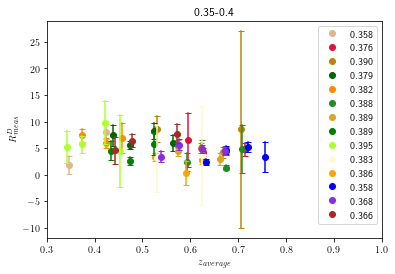

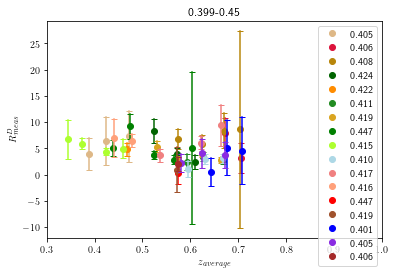

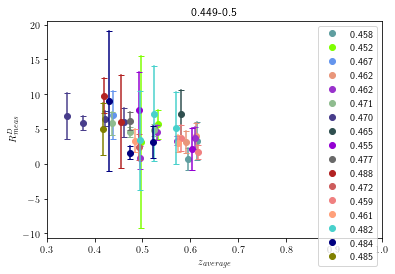

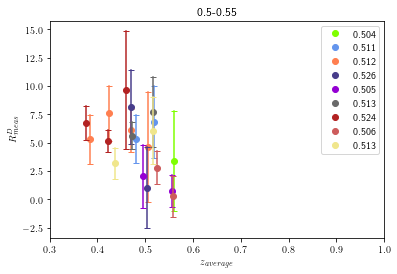

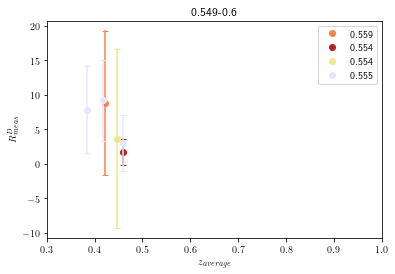

In [9]:
Q2 = Q2s[1]
for key_xbj,xbj_value in RDxz[Q2_str[1]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #print(xbj)
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RDi=float(z_value["value"])
            RDi_error = float(z_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(z_value["z_corr"])
            zs.append(zi_corr)
            xbji_corr = float(z_value["xbj_corr"])
            #print(z_value["xbj_corr"])
            xbji_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbji_corr)
            xbj_corr_errs.append(xbji_corr_err)
            ax.plot([zi_corr,zi_corr],[RDi+RDi_error,RDi-RDi_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        #print(xbj_corr)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = xbj_corr_str[0:5])
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        #RD_xbj = Get_weighted_average(RDs,RDs_error)
        #RD_xbj_err = Get_weighted_sigma(RDs,RDs_error)
        #RDs_xbj.append(RD_xbj)
        #RDs_xbj_err.append(RD_xbj_err)
        

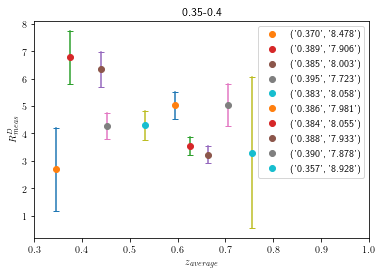

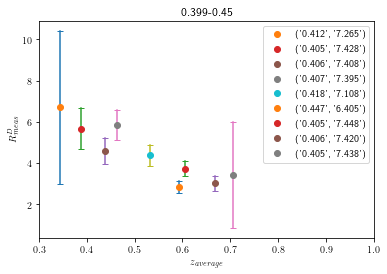

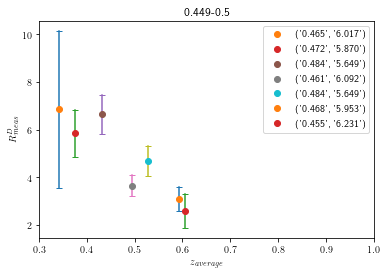

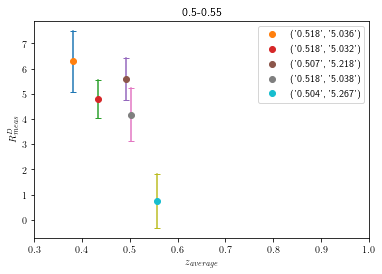

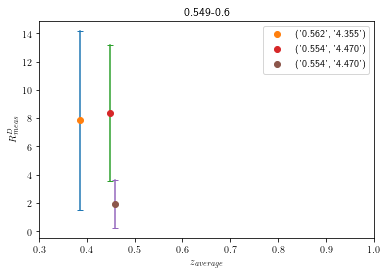

In [10]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[1]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_two_corr = []
    xbj_two_err_corr = []
    CSV_two = []
    CSV_two_err = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_two_corr.append(xbj_corr)
        xbj_twoi_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_two_err_corr.append(xbj_twoi_err_corr)
        CSV_two.append(CSVxi)
        CSV_two_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_two = Get_weighted_average(xbj_two_corr,xbj_two_err_corr)
    xbj_twos_corr.append(xbj_two)
    CSVxi_two = Get_weighted_average(CSV_two,CSV_two_err)
    CSVxi_two_err = Get_weighted_sigma(CSV_two,CSV_two_err)
    CSV_twos.append(CSVxi_two)
    CSV_twos_err.append(CSVxi_two_err)

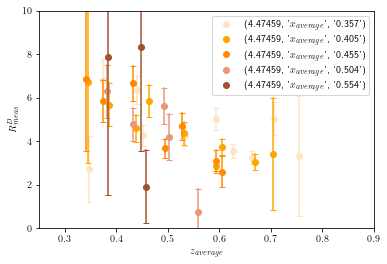

In [11]:
##caution!!! wrong xbj
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[1]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$x_{average}$',str(xbj_corr)[0:5]),color = colors_all[i_color])
    plt.xlabel(r'$z_{average}$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.ylim(0,10)
    plt.legend()
    i_color +=1
    plt.savefig(f"/Users/shuojia/CSV/results/ratios/RDmeas_Q2nd_Q2cut")

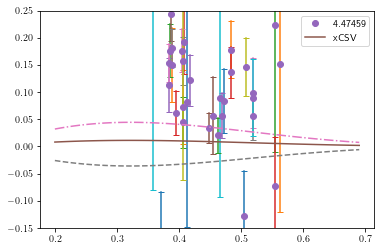

In [12]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o",label = Q2)
        #CSVs_err
    


plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.ylim(-0.15,0.25)
plt.legend()

2.319483476687897


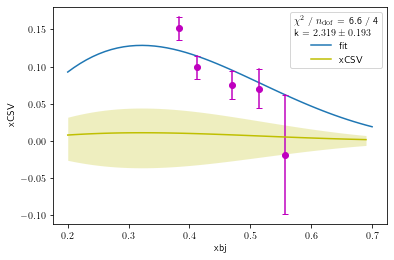

In [13]:
fig, ax = plt.subplots()
least_squares_two = LeastSquares(xbj_twos_corr,CSV_twos,CSV_twos_err,MRST_xCSV)
m_two = Minuit(least_squares_two, k=0.2)
m_two.migrad()  # finds minimum of least_squares function
m_two.hesse()   # accurately computes uncertainties
print(*m_two.values)
fit_CSV_two=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_two.append(MRST_xCSV(xi,*m_two.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_two, label="fit")


# display legend with some fit info
fit_info_two = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_two.fval:.1f} / {len(xbj_twos_corr) - m_two.nfit}",
]
for p_two, v_two, e_two in zip(m_two.parameters, m_two.values, m_two.errors):
    fit_info_two.append(f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")


for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')

plt.legend(title="\n".join(fit_info_two))
#plt.legend()

Text(0, 0.5, 'xCSV')

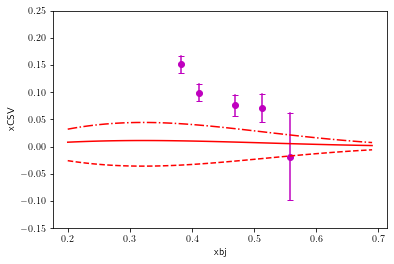

In [14]:
ax = fig.add_subplot()
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo")
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.ylim(-0.15,0.25)
plt.xlabel('xbj')
plt.ylabel('xCSV')

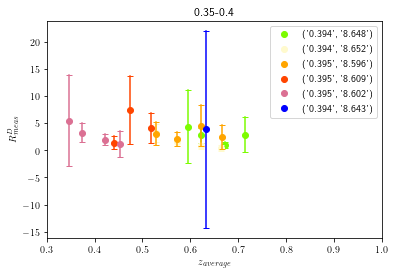

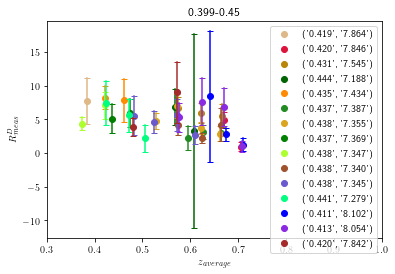

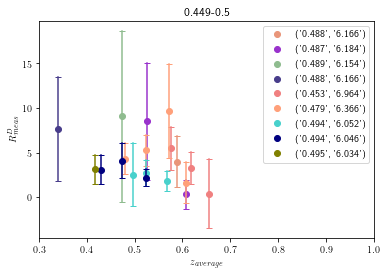

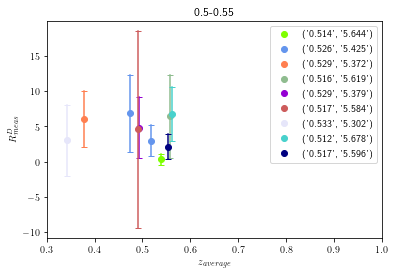

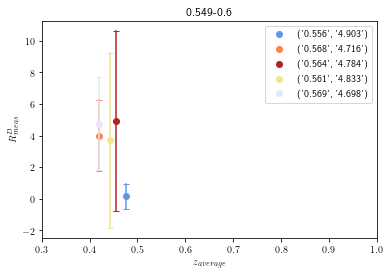

In [15]:
Q2 = Q2s[2]
for key_xbj,xbj_value in RDxz[Q2_str[2]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    #color = ['b','g','r','c','m','y','firebrick','salmon','sienna','orange','tan','peachpuff','teal','hotpink']
    for key_rungroup,rungroup_value in xbj_value.items():
        RunGroup = int(key_rungroup)
        zs = []
        RDs = []
        RDs_error = []
        #print(RunGroup)
        xbj_corrs = []
        xbj_corr_errs = []
        for key_z, z_value in rungroup_value.items():
            z_hadron = float(key_z)#+0.0001*RunGroup
            #print(z_hadron)
            #zs.append(z_hadron)
            RD=float(z_value["value"])
            RD_error = float(z_value["error"])
            RDs.append(float(z_value["value"]))
            RDs_error.append(float(z_value["error"]))
            z_corr = float(z_value["z_corr"])
            zs.append(z_corr)
            xbj_corr = float(z_value["xbj_corr"])
            xbj_corr_err = float(z_value["xbj_corr_err"])
            xbj_corrs.append(xbj_corr)
            xbj_corr_errs.append(xbj_corr_err)
            ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        
        xbj_corr = Get_weighted(xbj_corrs,xbj_corr_errs)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_corr_str = str(xbj_corr)
        plt.plot(zs,RDs,"o",color = colors[RunGroup//10],label = (xbj_corr_str[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])


      



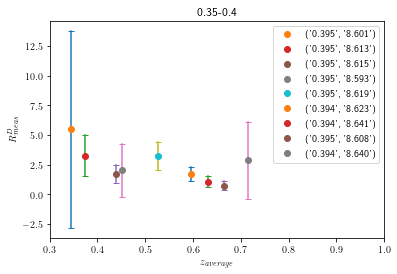

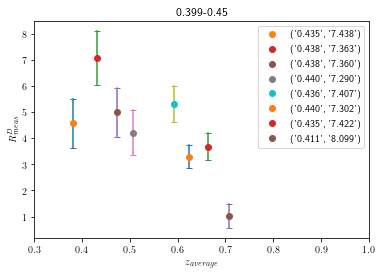

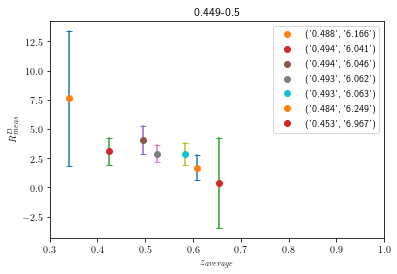

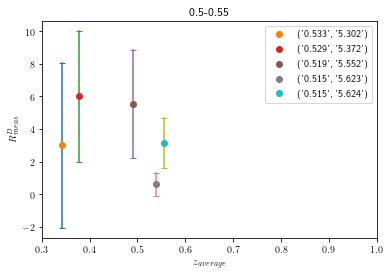

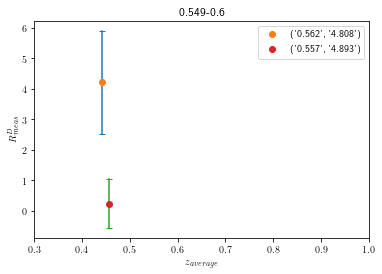

In [16]:
CSVs = []
CSVs_err = []
xbj_all_corr=[]
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[2]].items():
    xbj = float(key_xbj) 
    fig = plt.figure()
    ax = fig.add_subplot()
    
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        xbj_three_corr = []
        xbj_three_err_corr = []
        CSV_three = []
        CSV_three_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        xbj_all_corr.append(xbj_corr)
        CSVxi = xbj_corr*CSVx(math.sqrt(Q2),z_corr,xbj_corr,RD)
        CSVxi_err = xbj_corr*CSVx_err(math.sqrt(Q2),z_corr,xbj_corr,RD_err)
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_three_corr.append(xbj_corr)
        xbj_threei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_three_err_corr.append(xbj_threei_err_corr)
        CSV_three.append(CSVxi)
        CSV_three_err.append(CSVxi_err)
        ax.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_")
        plt.plot(z_corr,RD,"o",label = (str(xbj_corr)[0:5],str(W2)[0:5]))
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$R^D_{meas}$')
        plt.xlim(0.3,1)
        plt.legend()
        ax.set_title(str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
    xbj_three = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    xbj_threes_corr.append(xbj_three)
    CSVxi_three = Get_weighted_average(CSV_three,CSV_three_err)
    CSVxi_three_err = Get_weighted_sigma(CSV_three,CSV_three_err)
    CSV_threes.append(CSVxi_three)
    CSV_threes_err.append(CSVxi_three_err)

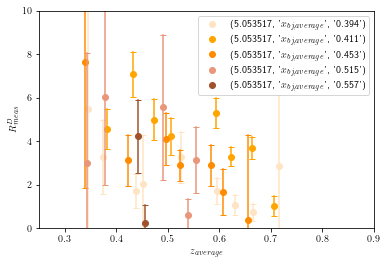

In [17]:
i_color = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black']
for key_xbj,xbj_value in RD_Q2xzRG[Q2_str[2]].items():
    xbj = float(key_xbj) 
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RD_alls = []
    for key_z,z_value in xbj_value.items():
        z_hadron = float(key_z)
        RDs = []
        RDs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        for key_RunGroup,RunGroup_value in z_value.items():
            RunGroup = float(key_RunGroup)
            RDi=float(RunGroup_value["value"])
            RDi_error = float(RunGroup_value["error"])
            RDs.append(RDi)
            RDs_error.append(RDi_error)
            zi_corr = float(RunGroup_value["z_corr"])
            zs_corr.append(zi_corr)
            zi_corr_err = float(RunGroup_value["z_corr_err"])
            zs_corr_err.append(zi_corr_err)
            xbji_corr = float(RunGroup_value["xbj_corr"])
            xbji_corr_err = float(RunGroup_value["xbj_corr_err"])
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RD = Get_weighted_average(RDs,RDs_error)
        RD_err = Get_weighted_sigma(RDs,RDs_error)
        W2 = 0.938**2+Q2*(1-xbj_corr)/xbj_corr
        #xbj_corrs.append(xbj_corr)
        z_corrs.append(z_corr)
        RD_alls.append(RD)
        plt.plot([z_corr,z_corr],[RD+RD_err,RD-RD_err],marker = "_",color = colors_all[i_color])
    plt.plot(z_corrs,RD_alls,"o",label = (Q2,r'$ x_{bj,average}$',str(xbj_corr)[0:5]),color = colors_all[i_color])
    plt.xlabel(r'$z_{average}$')
    plt.ylabel(r'$R^D_{meas}$')
    plt.xlim(0.25,0.9)
    plt.legend()
    plt.ylim(0,10)
    #print(Q2)
    i_color +=1
    plt.savefig(f"/Users/shuojia/CSV/results/ratios/RDmeas_Q2rd_Q2cut")

Text(0.5, 0, '$x_{bj}$')

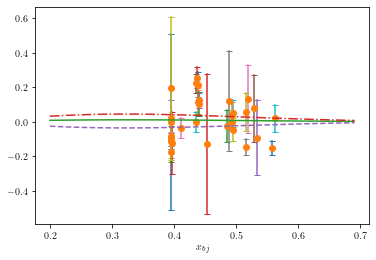

In [18]:
ax = fig.add_subplot()
for i in range(len(CSVs_err)):
    plt.plot([xbj_all_corr[i],xbj_all_corr[i]],[CSVs[i]-CSVs_err[i],CSVs[i]+CSVs_err[i]],marker = "_")
plt.plot(xbj_all_corr,CSVs,"o")
        #CSVs_err
    


plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')

#plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel(r'$x_{bj}$')
#plt.ylim(-0.3,0.6)

-2.2248926099510573


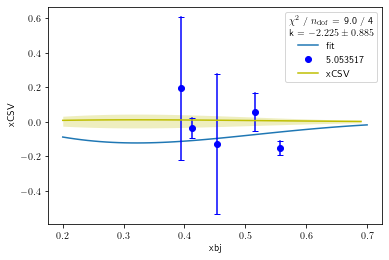

In [19]:
fig, ax = plt.subplots()
least_squares_three = LeastSquares(xbj_threes_corr,CSV_threes,CSV_threes_err,MRST_xCSV)
m_three = Minuit(least_squares_three, k=0.2)
m_three.migrad()  # finds minimum of least_squares function
m_three.hesse()   # accurately computes uncertainties
print(*m_three.values)
fit_CSV_three=[]

#for xi in xbj_ones_corr:
for xi in xbj_axis:
    fit_CSV_three.append(MRST_xCSV(xi,*m_three.values))


#plt.plot(xbj_ones_corr, fit_CSV_one, label="fit")
plt.plot(xbj_axis, fit_CSV_three, label="fit")


# display legend with some fit info
fit_info_three = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_three.fval:.1f} / {len(xbj_threes_corr) - m_three.nfit}",
]
for p_three, v_three, e_three in zip(m_three.parameters, m_three.values, m_three.errors):
    fit_info_three.append(f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")





for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = Q2)
        
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')

plt.legend(title="\n".join(fit_info_three))




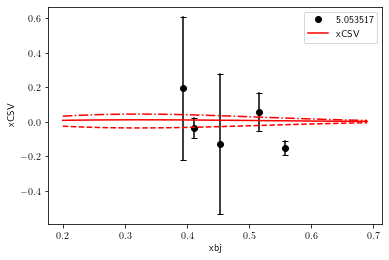

In [20]:
ax = fig.add_subplot()
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "k")
plt.plot(xbj_threes_corr,CSV_threes,"ko",label = Q2)
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
#plt.ylim(-0.3,0.6)
plt.legend()

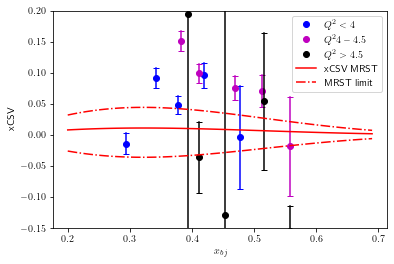

In [21]:
#ax = fig.add_subplot()
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "b")
plt.plot(xbj_ones_corr,CSV_ones,"bo",label = r'$Q^2 <4$')
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 4- 4.5$')
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "k")
plt.plot(xbj_threes_corr,CSV_threes,"ko",label = r'$Q^2 > 4.5$')
        
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV MRST',color = 'r')
plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.',label = 'MRST limit',color = 'r')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'-.',color = 'r')
plt.xlabel(r'$x_{bj}$')
plt.ylabel('xCSV')
plt.ylim(-0.15,0.2)
plt.legend()

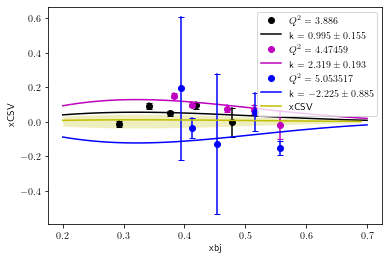

In [22]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
plt.plot(xbj_axis, fit_CSV_one, "k",label=f"{p_one} = ${v_one:.3f} \\pm {e_one:.3f}$")
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
plt.plot(xbj_axis, fit_CSV_two, "m",label=f"{p_two} = ${v_two:.3f} \\pm {e_two:.3f}$")
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))
plt.plot(xbj_axis, fit_CSV_three, "b",label=f"{p_three} = ${v_three:.3f} \\pm {e_three:.3f}$")


     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'xCSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel('xCSV')
#plt.ylim(-0.15,0.2)
plt.legend()
plt.savefig(f"/Users/shuojia/CSV/results/ratios/CSV_all_Q2cut_{FF_model[i_FF]}_fit")

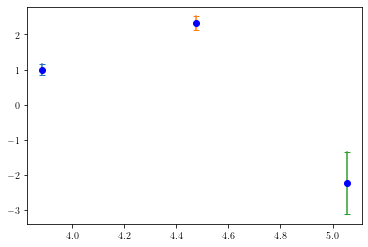

In [23]:
ks = []
kerrs = []
plt.plot([Q2s[0],Q2s[0]],[v_one-e_one,v_one+e_one],marker = "_")
plt.plot(Q2s[0],v_one,"bo")
plt.plot([Q2s[1],Q2s[1]],[v_two-e_two,v_two+e_two],marker = "_")
plt.plot(Q2s[1],v_two,"bo")
plt.plot([Q2s[2],Q2s[2]],[v_three-e_three,v_three+e_three],marker = "_")
plt.plot(Q2s[2],v_three,"bo")
ks.append(v_one)
ks.append(v_two)
ks.append(v_three)
kerrs.append(e_one)
kerrs.append(e_two)
kerrs.append(e_three)

with open('fitting_param_Q2cut.json') as jout_infile:
    jout = json.load(jout_infile)
#jout = {}

jout[FF_model[i_FF]] = {"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["fDSSNLO_2"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["fDSSLO_2"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["JAM20_2"]={"Q2":Q2s,"k":ks,"kerr":kerrs}
#jout["Geiger_2"]={"Q2":Q2s,"k":ks,"kerr":kerrs}

with open('fitting_param_Q2cut.json','w') as outfile:
    json.dump(jout,outfile,indent = 4)